<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 2: Ames Housing Project with Linear Regression

### Contents:
- [Data Import](#Data-Import)
- [Optimise Ordinal Categories](#Optimise-Ordinal-Categories)
- [Trade Off: Higher RMSE for reduced features and better interpretability](#Trade-Off:-Higher-RMSE-for-reduced-features-and-better-interpretability)
- [Data Visualization](#Visualize-the-Data)
- [Kaggle Submission](#Kaggle-Submission)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)

In [487]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import metrics
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import (
    Ridge,RidgeCV,
    Lasso,LassoCV,
    ElasticNet, ElasticNetCV,
    LinearRegression
)
from sklearn.model_selection import(
    cross_val_score,
    train_test_split
)
from sklearn.preprocessing import (
    StandardScaler,
    PolynomialFeatures
)
from sklearn.feature_selection import SelectFromModel
# pd.set_option('display.max_rows', 1000)  # or 1000
# pd.set_option('display.max_columns', 1000)  # or 1000

from itertools import combinations
from itertools import permutations

from sklearn.preprocessing import OneHotEncoder

In [488]:
# defining lasso regression to better book kepe journal.
# outputs are X_train, X_test, y_train, y_test, lasso_best
# included indices as well in order to find outliers 

def lasso_reg(X_df,y_series,test_size):
    # assign X and y

    X = X_df
    y = y_series
    indices = X_df.index.values
    
    # Create train/test splits.
    X_train, X_test, y_train, y_test,indices_train, indices_test = train_test_split(
        X,
        y,
        indices,
        test_size=test_size,
        random_state = 123
    )

    # Scale our data.
    # Relabeling scaled data as "Z" is common.
    sc = StandardScaler()
    # Z_train = sc.fit_transform(X_train)
    sc.fit(X_train) # fit should only see train data, 
                    #else if put in test, will have leak from the train data 
    X_train = sc.transform(X_train)
    X_test = sc.transform(X_test)

    # initiate 
    lasso = LassoCV(
        cv=5,
        max_iter=50000,
        n_alphas=200,
    )

    # Fit model using best ridge alpha!
    lasso.fit(X_train, y_train);

    #fit lasso best with alpha 
    lasso_best = Lasso(alpha = lasso.alpha_)

    # fit lasso best 
    lasso_best.fit(X_train,y_train)

    # cross val mse
    cross_score = - cross_val_score(
        lasso_best,
        X_train,
        y_train,
        cv = 3,
        scoring = 'neg_mean_squared_error'
    ).mean()

    # test mse
    mse_test = mean_squared_error(
        y_test,
        lasso_best.predict(X_test)
    )
    # cross - test 
    mse_train_minus_test = cross_score - mse_test

    if mse_train_minus_test > 0:
        print(f'MSE for train: {cross_score}')
        print(f'MSE for test: {mse_test}')
        print(f'Underfited by: {mse_train_minus_test}')
    else:
        print(f'MSE for train: {cross_score}')
        print(f'MSE for test: {mse_test}')
        print(f'Overfitted by: {mse_train_minus_test}')
    print(f'RMSE: {mse_test**0.5}')
    print(f'Lasso alpha used: {lasso.alpha_}')
    
    return X_train, X_test, y_train, y_test, lasso_best, indices_train, indices_test

### Data Import

In [489]:
# Read temp file

df_main_refined = pd.read_csv('datasets/For_feature_engineering.csv')

## Add interaction terms

The main reason why we are looking into interaction terms is to cater for the combined effect of supposed "independent" features and put a value into it in order to better predict housing prices. 

This method aims to hopefully provide a feature that is highly correlated to price hence, subsequently added into the model for better price prediction.

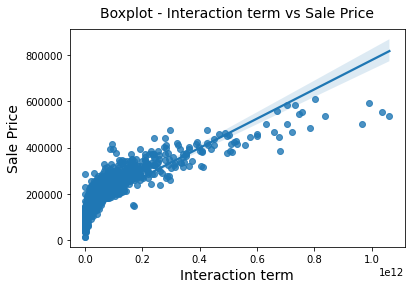

In [490]:
# adding interaction terms based on EDA in first journal

df_main_refined['interaction_1'] = df_main_refined['lot_area']**0.5 *\
df_main_refined['overall_qual']*df_main_refined['kitchen_qual']*\
df_main_refined['exter_qual']* df_main_refined['bsmt_qual']* df_main_refined['heating_qc']*\
df_main_refined['total_bsmt_sf']**0.5 * df_main_refined['1st_flr_sf']**0.5 *df_main_refined['gr_liv_area']**0.5\
* df_main_refined['tot_rms_abv_grd']

# plot regplot of interaction term against price
ax = sns.regplot(
    x = 'interaction_1',
    y = 'sale_price',
    data = df_main_refined
)
# set labels
ax.set_title('Boxplot - Interaction term vs Sale Price', fontdict={'fontsize': 14}, pad = 12)
ax.set_xlabel('Interaction term' , fontdict={'fontsize': 14})
ax.set_ylabel('Sale Price', fontdict={'fontsize': 14});


*comments*

- interaction term is highly correlated to sales price 
- High in magnitude 
- improved RMSE of 18% 

**Split Test and Train data** 

In [491]:
# declare indexer 
indexer = df_main_refined.shape[0] - len(df_main_refined[pd.isnull(df_main_refined['sale_price'])])
print(f'Indexer: {indexer}')

# split test data (Kaggle)
# cross check -->> OK

kaggle_test_final = main_data[indexer:]
kaggle_test_final = kaggle_test_final.reset_index(drop = 'index')
print(kaggle_test_final['sale_price'].head(10))

# split train data (Kaggle)

kaggle_train_final = main_data[:indexer]
kaggle_train_final['sale_price'].tail(10)

Indexer: 2049
0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
6   NaN
7   NaN
8   NaN
9   NaN
Name: sale_price, dtype: float64


2039    412500.0
2040     83000.0
2041    128000.0
2042    182000.0
2043    394617.0
2044    298751.0
2045     82500.0
2046    177000.0
2047    144000.0
2048    189000.0
Name: sale_price, dtype: float64

**Redo Lasso that includes Interaction Term**

In [492]:
# redo scale and lasso 
X_train, X_test, y_train, y_test, lasso_best,indices_train, indices_test= lasso_reg(
    X_df = kaggle_train_final.drop(columns = ['sale_price','id']),
    y_series = kaggle_train_final['sale_price'],
    test_size = 0.3
)

MSE for train: 447036861.7194271
MSE for test: 349084931.3089039
Underfited by: 97951930.41052324
RMSE: 18683.814688358045
Lasso alpha used: 190.23925915214406


Text(27.125, 0.5, 'Actual Sale Price')

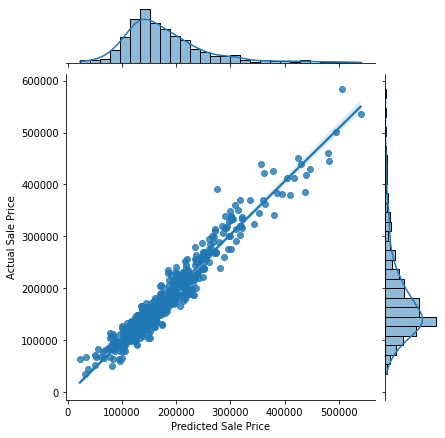

In [493]:
# noticed still have some outliers 

ax1 = sns.jointplot(
    x = lasso_best.predict(X_test),
    y = y_test,
    kind = 'reg',
)
ax1.ax_joint.set_xlabel('Predicted Sale Price')
ax1.ax_joint.set_ylabel('Actual Sale Price')


**Improvement - No more skewness**

We can observe the significant change in the shape of the predicted prices, matching closely to Actual price just after adding interaction term. This shows that indeed in the real world, it suggest that these features are collinear and might have greater impact if interacting with one another, depicting how we usually view houses, considering multiple features all as a whole, picturing the overall house quality in our heads. 

## Optimise model

<AxesSubplot:>

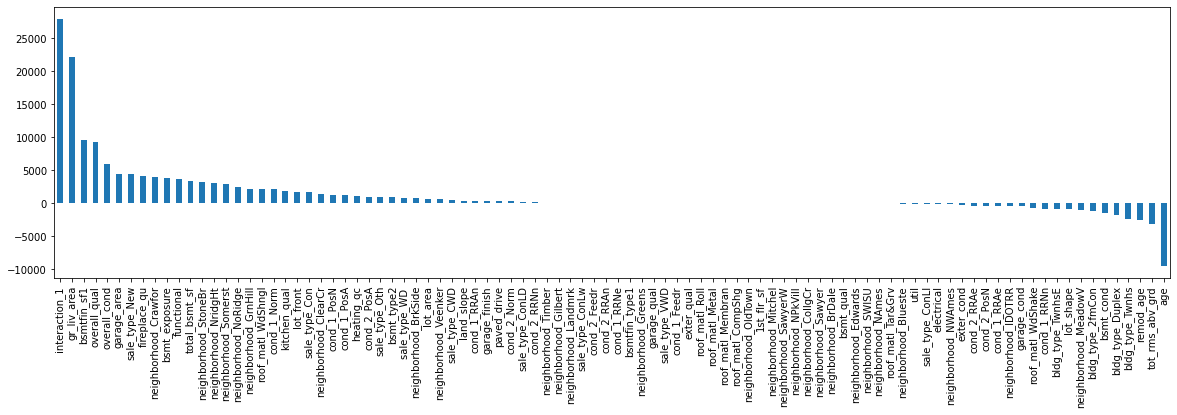

In [494]:
# to plot the series 
# too many variables, need to scale down the number of features 
plt.figure(figsize=(20,5))

col = kaggle_train_final.columns.drop(['sale_price', 'id'])
pd.Series(lasso_best.coef_, index = col).sort_values(ascending = False).plot.bar()

As we have quite a huge number of features, it is hard to interpret most of them, especially if there are features with zero coefficients, indicating that assuming the rest of the features constant, that particular feature might not lead to an increase price of housing. Hence we can drop these by masking. 

In [495]:
# fitting feature_set_model

feature_set_model = SelectFromModel(lasso_best)
feature_set_model.fit(X_train,y_train)

SelectFromModel(estimator=Lasso(alpha=190.23925915214406))

In [496]:
# check boolean array of cofficients to be removed 
# this will be used for masking 
feature_set_model.get_support()

array([ True,  True,  True,  True,  True, False, False,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
       False,  True,  True,  True,  True, False,  True,  True, False,
        True,  True,  True, False,  True,  True, False,  True, False,
        True, False,  True,  True,  True, False,  True, False, False,
        True,  True,  True,  True, False, False, False, False,  True,
        True,  True, False,  True,  True,  True,  True,  True, False,
        True, False,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True, False,  True,  True])

In [497]:
#refined model from 183 columns to 79 columns 

refined = list(kaggle_train_final.columns.drop(['sale_price','id'])[feature_set_model.get_support()])
len(refined)

70

In [498]:
# redo scale and lasso 
# reduced by hundred. 
X_train, X_test, y_train, y_test, lasso_best, indices_train, indices_test = lasso_reg(
    X_df = kaggle_train_final.loc[:,refined],
    y_series = kaggle_train_final['sale_price'],
    test_size = 0.3
)

MSE for train: 441232067.5084603
MSE for test: 347764461.9751481
Underfited by: 93467605.5333122
RMSE: 18648.443955867955
Lasso alpha used: 67.14889022953919


<AxesSubplot:>

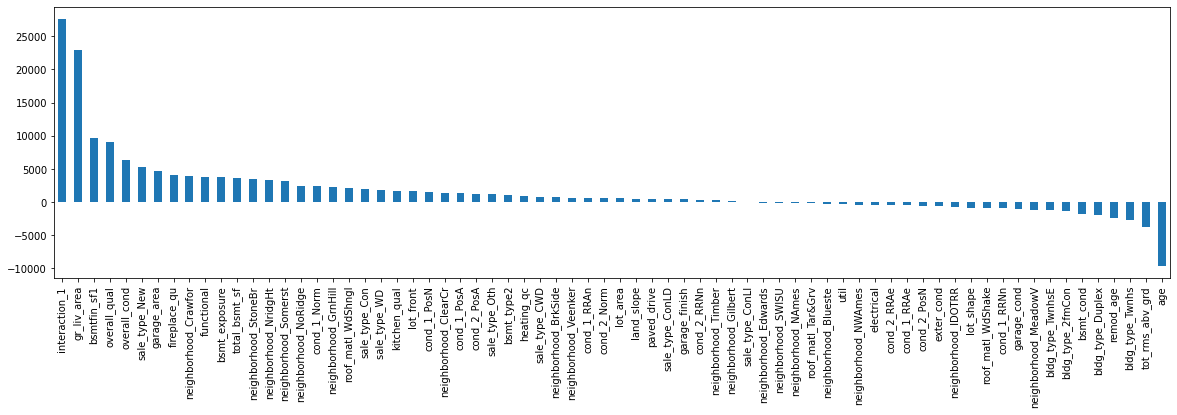

In [499]:
plt.figure(figsize=(20,5))

col = kaggle_train_final.loc[:,refined].columns
pd.Series(lasso_best.coef_, index = col).sort_values(ascending = False).plot.bar()

In [500]:
print(f'Total number of features: {len(kaggle_train_final.loc[:,refined].columns)}')
(kaggle_train_final.loc[:,refined].columns)

Total number of features: 70


Index(['lot_front', 'lot_area', 'overall_qual', 'age', 'remod_age',
       'heating_qc', 'total_bsmt_sf', 'gr_liv_area', 'kitchen_qual',
       'garage_finish', 'fireplace_qu', 'garage_area', 'bsmtfin_sf1',
       'tot_rms_abv_grd', 'lot_shape', 'util', 'land_slope', 'exter_cond',
       'bsmt_cond', 'bsmt_exposure', 'bsmt_type2', 'electrical', 'functional',
       'garage_cond', 'paved_drive', 'overall_cond', 'neighborhood_Blueste',
       'neighborhood_BrkSide', 'neighborhood_ClearCr', 'neighborhood_Crawfor',
       'neighborhood_Edwards', 'neighborhood_Gilbert', 'neighborhood_GrnHill',
       'neighborhood_IDOTRR', 'neighborhood_MeadowV', 'neighborhood_NAmes',
       'neighborhood_NWAmes', 'neighborhood_NoRidge', 'neighborhood_NridgHt',
       'neighborhood_SWISU', 'neighborhood_Somerst', 'neighborhood_StoneBr',
       'neighborhood_Timber', 'neighborhood_Veenker', 'roof_matl_Tar&Grv',
       'roof_matl_WdShake', 'roof_matl_WdShngl', 'cond_1_Norm', 'cond_1_PosA',
       'cond_1_PosN

**After Lasso Zero Coefficients removed**

There are some findings observed;
1) Generally, as the bigger the area, the higher the price of the house.
2) There is an interesting discovery which was not covered in EDA, whereby neighbourhood of Crawford has a higher coefficient than the rest of the highlighted few like StoneBrooks, Northridge Heights, NorthRdige and GrnHill. 
3) Noticeably, having houses categorised as sale_type_new will have an advantage having a better house valuation assuming the rest constant. 

## Trade Off: Higher RMSE for reduced features and better interpretability

Need to create a separate dataframe that contains 
1) Lasso coefficients 
2) Feature names from the training data after train split (consider only refined columns )

In [501]:
# Creating filter df to tell us remaining columns needed for final model

# to create df for lasso coeff

lasso_coeff = pd.DataFrame(lasso_best.coef_)
lasso_coeff.reset_index(drop = True, inplace= True)
lasso_coeff.rename(columns = {0: 'lasso_coeff'}, inplace = True)

# to create df for features - consider only refined columns 
feat = pd.DataFrame(kaggle_train_final.loc[:,refined].columns)
feat.reset_index(drop = True, inplace = True)
feat.rename(columns = {0: 'feature'}, inplace = True)


# combine df and filter off columns for 

filter_df = pd.concat([lasso_coeff,feat], axis = 1)

filter_df['feature_in_main'] = filter_df['feature'].map(lambda x: True if x in main_variables else False)

# blanket value to limit the coeffcients
val = 1500

# take into consideration 
# 1) feature is not in main as to not touch any features from main variables 
# 2) lasso coefficient below and above val 
# 3) Need to include all features from main too 
filter_df2 = filter_df[
    (
    (filter_df['feature_in_main'] == False) & ((filter_df['lasso_coeff'] >= val) | (filter_df['lasso_coeff'] <= -val))
    ) 
    | (filter_df['feature_in_main'] == True)
    ]

print((f'Remaining columns in final model: {len(filter_df2)}'))
filter_df2.sort_values(by = 'lasso_coeff', ascending = False)

Remaining columns in final model: 33


,lasso_coeff,feature,feature_in_main
69,27617.091546,interaction_1,False
7,22938.147038,gr_liv_area,True
12,9686.877676,bsmtfin_sf1,True
2,9026.821109,overall_qual,True
25,6341.352939,overall_cond,False
66,5262.808994,sale_type_New,False
11,4672.514037,garage_area,True
10,4040.920213,fireplace_qu,True
29,4009.672573,neighborhood_Crawfor,False
22,3818.714064,functional,False


Removed from 70 features to 33 features with this method above

In [502]:
# Extracting Refined columns 
# Noted that we can remove 'gr_liv_area_class' as they are poor scored against RMSE

filter_columns = [col for col in list(filter_df2['feature'])]
filter_columns

['lot_front',
 'lot_area',
 'overall_qual',
 'age',
 'remod_age',
 'heating_qc',
 'total_bsmt_sf',
 'gr_liv_area',
 'kitchen_qual',
 'garage_finish',
 'fireplace_qu',
 'garage_area',
 'bsmtfin_sf1',
 'tot_rms_abv_grd',
 'bsmt_cond',
 'bsmt_exposure',
 'functional',
 'overall_cond',
 'neighborhood_Crawfor',
 'neighborhood_GrnHill',
 'neighborhood_NoRidge',
 'neighborhood_NridgHt',
 'neighborhood_Somerst',
 'neighborhood_StoneBr',
 'roof_matl_WdShngl',
 'cond_1_Norm',
 'cond_1_PosN',
 'bldg_type_Duplex',
 'bldg_type_Twnhs',
 'sale_type_Con',
 'sale_type_New',
 'sale_type_WD ',
 'interaction_1']

In [503]:
#  Scale and Lasso regression on refined columns 

X_train, X_test, y_train, y_test, lasso_best, indices_train, indices_test = lasso_reg(
    X_df = kaggle_train_final[filter_columns],
    y_series = kaggle_train_final['sale_price'],
    test_size = 0.3,
)

MSE for train: 439619906.07415986
MSE for test: 359390168.50734574
Underfited by: 80229737.56681412
RMSE: 18957.58867860957
Lasso alpha used: 67.14889022953919


**Trade off takeaways**

- RMSE increased from 18648 to 18869, an increase of 1% for reduction of 37 features
- This proves to be an efficient way of streamlining features to make it more interpretable 

Text(27.125, 0.5, 'Actual Sale Price')

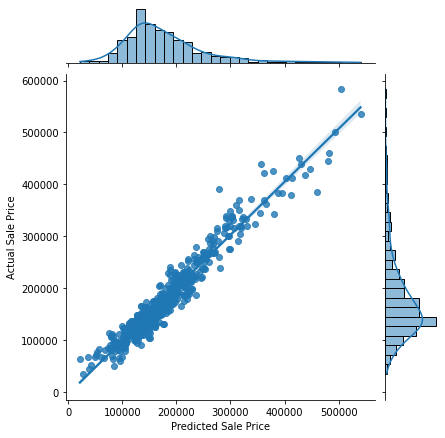

In [504]:
# noticed still have some outliers 

ax2 = sns.jointplot(
    x = lasso_best.predict(X_test),
    y = y_test,
    kind = 'reg',
)
ax2.ax_joint.set_xlabel('Predicted Sale Price')
ax2.ax_joint.set_ylabel('Actual Sale Price')


Text(0.5, 1.0, 'Predictions vs Residults from Lasso regression')

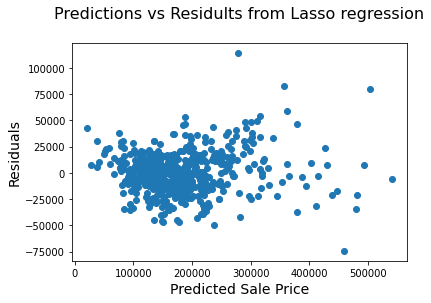

In [505]:
residuals = y_test - lasso_best.predict(X_test)
plt.scatter(lasso_best.predict(X_test), residuals)
plt.xlabel('Predicted Sale Price', fontdict={'fontsize': 14})
plt.ylabel('Residuals', fontdict={'fontsize': 14})
plt.title('Predictions vs Residults from Lasso regression',  fontdict={'fontsize': 16}, pad = 25)

**Comment**

- consistently seeing high outlier at predicted price of $300000

In [506]:
# find out number 286, 317 having anomaly
anomaly = [num for num,val in enumerate (residuals > 100000) if val == True]
anomaly

[286]

In [507]:
#index with anomoly
anomoly = [indices_test[anol] for anol in anomaly]
anomoly

[1135]

In [508]:
# ID filter into main dataframe
id_filter = [int(df_main_refined.loc[df_main_refined.index == outlier, 'id'].values) for outlier in anomoly]
id_filter

[1641]

In [509]:
# Referencing new set of columns 

final_columns = kaggle_train_final[filter_df2['feature']].columns 

In [510]:
# creating df to compare outliers between holdup and train score

reference_df = pd.concat([df_main_refined[['id','sale_price']],df_main_refined[final_columns]], axis = 1)
reference_df

,id,sale_price,lot_front,lot_area,overall_qual,age,remod_age,heating_qc,total_bsmt_sf,gr_liv_area,...,neighborhood_StoneBr,roof_matl_WdShngl,cond_1_Norm,cond_1_PosN,bldg_type_Duplex,bldg_type_Twnhs,sale_type_Con,sale_type_New,sale_type_WD,interaction_1
0,109,130500.0,69.0552,13517,6,34,5,5,725.0,1479,...,0,0,0,0,0,0,0,0,1,2.800761e+10
1,544,220000.0,43.0000,11492,7,13,12,5,913.0,2122,...,0,0,1,0,0,0,0,0,1,8.079403e+10
2,153,109000.0,68.0000,7922,5,57,3,3,1057.0,1057,...,0,0,1,0,0,0,0,0,1,8.258357e+09
3,318,174000.0,73.0000,9802,5,4,3,4,384.0,1444,...,0,0,1,0,0,0,0,0,1,1.013500e+10
4,255,138500.0,82.0000,14235,6,110,17,3,676.0,1445,...,0,0,1,0,0,0,0,0,1,6.608194e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2922,1662,NaN,80.0000,8000,6,33,33,3,1084.0,1877,...,0,0,0,1,0,0,0,0,1,1.633175e+10
2923,1234,NaN,90.0000,14670,6,42,9,5,1104.0,1988,...,0,0,1,0,0,0,0,0,1,7.726758e+10
2924,1373,NaN,55.0000,8250,5,40,40,5,952.0,1211,...,0,0,0,0,0,0,0,0,1,1.145416e+10
2925,1672,NaN,60.0000,9000,4,36,36,3,864.0,864,...,0,0,1,0,0,0,0,0,1,3.903075e+09


In [511]:
# Declare indexer to split between Train and Test sets

indexer = reference_df.shape[0] - len(reference_df[pd.isnull(reference_df['sale_price'])])
print(f'Indexer: {indexer}')

Indexer: 2049


In [512]:
#do cross test split with same random state to keep it consistent

X = reference_df[:indexer].drop(columns = 'sale_price')
y = reference_df[:indexer]['sale_price']

X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.3,
        random_state = 123
)

In [513]:
# creating holdup reference df
holdup = pd.DataFrame(X_test)
holdup.columns = reference_df.columns.drop('sale_price')
holdup['sale_price'] = y_test
holdup

,id,lot_front,lot_area,overall_qual,age,remod_age,heating_qc,total_bsmt_sf,gr_liv_area,kitchen_qual,...,roof_matl_WdShngl,cond_1_Norm,cond_1_PosN,bldg_type_Duplex,bldg_type_Twnhs,sale_type_Con,sale_type_New,sale_type_WD,interaction_1,sale_price
564,1039,34.0000,4060,6,10,9,5,1405.0,1337,4,...,0,1,0,0,0,0,0,0,3.065518e+10,181000.0
785,1976,50.0000,6000,6,80,57,3,845.0,1296,3,...,0,1,0,0,0,0,0,1,6.955894e+09,127500.0
553,141,69.0552,8050,5,51,51,3,1143.0,1143,3,...,0,1,0,0,0,0,0,1,8.425071e+09,136000.0
103,728,72.0000,9392,3,109,59,3,245.0,797,3,...,0,1,0,0,0,0,0,1,9.792767e+08,44000.0
1881,1755,69.0552,8740,7,5,5,5,854.0,1995,4,...,0,1,0,0,0,0,0,1,6.427632e+10,219500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1505,1821,70.0000,7420,5,45,45,3,1057.0,1057,3,...,0,1,0,0,0,0,0,1,7.193176e+09,132000.0
1476,1640,61.0000,8035,9,1,1,5,1612.0,1612,5,...,0,1,0,0,0,0,0,1,1.566406e+11,319900.0
995,2672,65.0000,6435,6,67,56,4,972.0,1577,2,...,0,0,0,0,0,0,0,1,8.025856e+09,140200.0
1907,60,108.0000,14774,9,11,11,5,1393.0,2599,4,...,0,1,0,0,0,0,0,1,2.511713e+11,333168.0


In [514]:
# creating train set reference df
train_set = pd.DataFrame(X_train)
train_set.columns = reference_df.columns.drop('sale_price')
train_set['sale_price'] = y_train
train_set

,id,lot_front,lot_area,overall_qual,age,remod_age,heating_qc,total_bsmt_sf,gr_liv_area,kitchen_qual,...,roof_matl_WdShngl,cond_1_Norm,cond_1_PosN,bldg_type_Duplex,bldg_type_Twnhs,sale_type_Con,sale_type_New,sale_type_WD,interaction_1,sale_price
807,944,60.0000,10200,4,84,59,2,572.0,572,3,...,0,1,0,0,0,0,0,1,1.193735e+09,75000.0
1316,2596,60.0000,10410,3,76,5,5,713.0,713,4,...,0,1,0,0,0,0,0,1,5.244733e+09,99800.0
655,1037,63.0000,7560,5,37,37,3,864.0,864,3,...,0,1,0,0,0,0,0,1,5.962045e+09,123000.0
1809,547,70.0000,7703,6,17,17,5,816.0,1730,4,...,0,1,0,0,0,0,0,1,3.467153e+10,171500.0
1296,33,53.0000,4043,6,33,33,3,1069.0,1069,3,...,0,1,0,0,0,0,0,1,5.760410e+09,127500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041,1363,69.0552,10320,5,93,30,4,880.0,1308,3,...,0,1,0,0,0,0,0,1,1.047542e+10,120000.0
1766,1907,80.0000,9600,5,52,52,5,1078.0,1150,3,...,0,1,0,0,0,0,0,1,1.498297e+10,144000.0
1122,14,85.0000,10176,7,20,20,4,1300.0,1341,4,...,0,1,0,0,0,0,0,1,3.277618e+10,171500.0
2012,454,34.0000,5122,6,4,4,5,1306.0,1306,4,...,0,1,0,0,1,0,0,1,3.242693e+10,184500.0


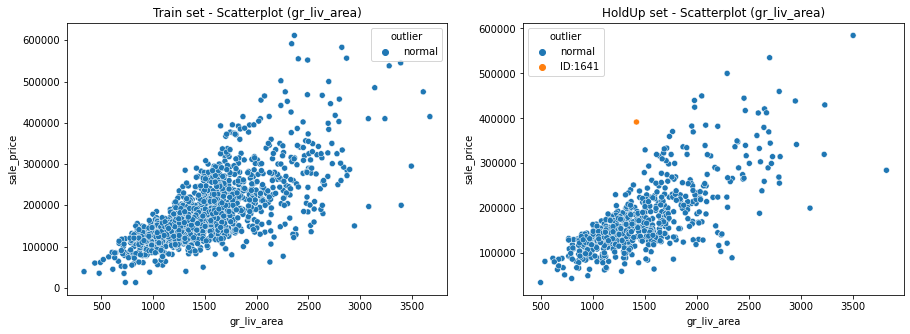

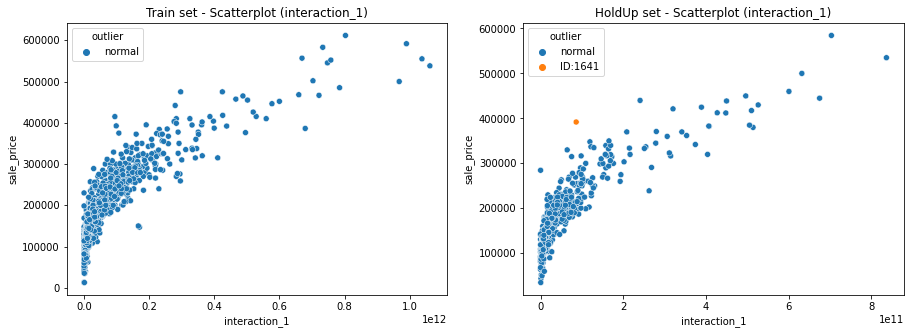

In [515]:
# Creating scatterplot against Sale price for Train and Holdup set

train_set['outlier'] = train_set['id'].map(lambda x: 'ID:1641' if x == id_filter[0] else 'normal')
holdup['outlier'] = holdup['id'].map(lambda x: 'ID:1641' if x == id_filter[0] else 'normal')

for var in ['gr_liv_area','interaction_1' ]:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    sns.scatterplot(ax = axes[0], x = var, y = 'sale_price', hue = 'outlier', data = train_set)
    axes[0].set_title(f'Train set - Scatterplot ({var})')
    
    sns.scatterplot(ax = axes[1], x = var, y = 'sale_price' , hue = 'outlier', data = holdup)
    axes[1].set_title(f'HoldUp set - Scatterplot ({var})')

**ID: 1641 Outlier** 
- From gr_liv_area in Holdup set, can see obvious flyer not consistent with Train set  

In [516]:
# **Remove outlier as very abnormal for sale price after renovation**

df_main_refined.drop(index = [1136], inplace = True)

In [517]:
# Declare indexer to split between Train and Test sets

indexer = df_main_refined.shape[0] - len(df_main_refined[pd.isnull(df_main_refined['sale_price'])])
print(f'Indexer: {indexer}')

Indexer: 2048


In [518]:
# declare X and y again

In [519]:
kaggle_test_final = df_main_refined[indexer:]
kaggle_test_final = kaggle_test_final.reset_index(drop = 'index')
print(kaggle_test_final['sale_price'].head())
kaggle_train_final = df_main_refined[:indexer]
kaggle_train_final['sale_price'].tail(10)

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: sale_price, dtype: float64


2039    412500.0
2040     83000.0
2041    128000.0
2042    182000.0
2043    394617.0
2044    298751.0
2045     82500.0
2046    177000.0
2047    144000.0
2048    189000.0
Name: sale_price, dtype: float64

In [520]:
#  Scale and Lasso regression on refined columns 

X_train, X_test, y_train, y_test, lasso_best, indices_train, indices_test = lasso_reg(
    X_df = kaggle_train_final[filter_columns],
    y_series = kaggle_train_final['sale_price'],
    test_size = 0.3,
)

MSE for train: 441304300.1937968
MSE for test: 362580143.1728812
Underfited by: 78724157.02091563
RMSE: 19041.537311175303
Lasso alpha used: 109.68391897234149


The MSE of both train and test, surprisingly became slightly worsened, suggesting it could be the effect of the iteraction term causing big shifts amongst other features as well. This is evident from the alpha change from 67 to 109, indicating the need to further penalize despite variables already scaled. 

In [521]:
# Change in RMSE 

RMSE_before_outlier_removed = 18957.58867860957
RMSE_after_outlier_removed = 19041.537311175303

Difference = RMSE_after_outlier_removed - RMSE_before_outlier_removed
percent_dif = round(Difference/RMSE_before_outlier_removed * 100, 2)
print(f'Current RMSE: {RMSE_after_outlier_removed}')
print(f'Difference in RMSE: {Difference}')
print(f'Percentage diff: {percent_dif}%')

Current RMSE: 19041.537311175303
Difference in RMSE: 83.94863256573444
Percentage diff: 0.44%


## Data Visualization and Recommendations

<AxesSubplot:>

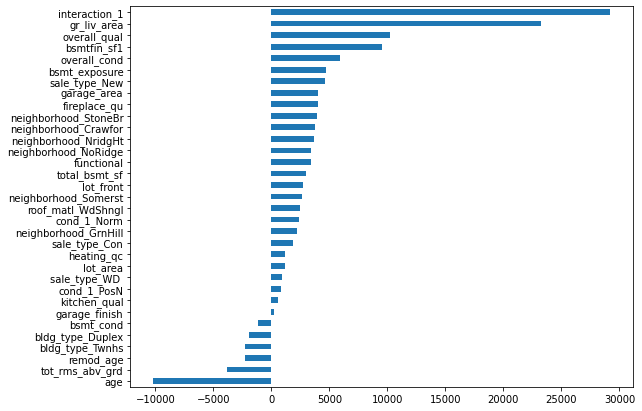

In [522]:
plt.figure(figsize=(9,7))
pd.Series(lasso_best.coef_, index = kaggle_train_final[filter_columns].columns).sort_values(ascending = True).plot.barh()

From these finalised visualization, we can observe:

1) There are some neighborhoods that has added value if houses are in those areas. Specifically to Stonebrooks, noted that the area is close to the main road, suggesting easier transportation to other cities, adding more value for buyers who are willing to pay for added ease to commute. 

2) Garage finish has a relatively strong coefficient to remain as top 33 features of the model. This tells us if the garage is still unfinished, potential sellers might want to consider doing some interior finish touch up to gain additional value for the house.

3) For houses with fireplace quality, sellers might want to beef up on their quality as it can easily help increase valuation of the price for every unit increase assuming all else constant.

4) Of all roof materials, Wood Shakes happens to have a high coeficient to the price of a house. Its coefficient is 2198.263399, buyers might consider changing the material if it is cheaper than the coefficient, as having it will increase the value of the house by that much assuming all else constant. 

## Kaggle Submission

In [523]:
# Declare whole train set as X

X = kaggle_train_final.drop(columns = ['sale_price','id'])
y = kaggle_train_final['sale_price']
lasso_best.fit(X,y)

Lasso(alpha=109.68391897234149)

In [524]:
# checking train shape 
kaggle_train_final.drop(columns = ['sale_price','id']).shape

(2048, 94)

In [525]:
# checking test shape
kaggle_test_final.drop(columns = ['sale_price','id']).shape

(878, 94)

In [526]:
# checking for any mis match in columns 

for col in kaggle_test_final.columns:
    if col not in kaggle_train_final.columns:
        print(col)

In [527]:
# Submission to kaggle 

In [528]:
# y prediction using whole Train Set
pred = lasso_best.predict(kaggle_test_final.drop(columns = ['sale_price','id']))

In [529]:
# create ID list 
id_list = list(kaggle_test_final['id'])

# create prediction list 
pred_list = list(pred)

# Create CSV 
Submission = pd.DataFrame(list(zip(id_list, pred_list)), columns = ['Id', 'SalePrice'])
Submission

,Id,SalePrice
0,2658,148766.904745
1,2718,160603.118851
2,2414,218301.586267
3,1989,106353.218657
4,625,167495.115632
...,...,...
873,1662,188318.425951
874,1234,220791.470885
875,1373,128981.175871
876,1672,116794.399493


In [530]:
Submission.to_csv('Submission/Submission.csv')

## Key Takeaways

1) Coming out with interaction terms to cater for the synergy effect by other supposed 'independant' variables 
    which turns out highly correlated to the sale price of the house 
   
2) Having put certain classisfiers to nail down certain groups of houses to certain class does not work well, as they work as pair wise. Having the original main set works best alone.